In [ ]:
%pip install -U lightgbm==3.3.2
%pip install implicit

     |████████████████████████████████| 2.0 MB 4.4 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3
     |████████████████████████████████| 18.5 MB 4.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

In [ ]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("/content/drive/MyDrive/HM-new/") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [ ]:
from src.data import DataHelper
from src.data.metrics import map_at_k, hr_at_k, recall_at_k

from src.retrieval.rules import (
    OrderHistory,
    ALS,
    BPR,
    UserGroupTimeHistory,
    OrderHistoryDecay,
    ItemPair,
    TimeHistory,
    ItemCF,
    UserGroupItemCF
)
from src.retrieval.collector import RuleCollector

from src.features import full_sale, week_sale, repurchase_ratio, popularity, period_sale

from src.utils import (
    calc_valid_date,
    merge_week_data,
    reduce_mem_usage,
    calc_embd_similarity,
)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data_dir = Path("/content/drive/MyDrive/HM-new/data/")
model_dir = Path("/content/drive/MyDrive/HM-new/models/")

In [ ]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2

VERSION_NAME = "LargeRecall"
TEST = True # * Set as `False` when do local experiments to save time

In [ ]:
TEST_BATCH_SIZE = 70000
TEST_BATCH_NUM = 10 # 1371980 / 70000

In [ ]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)
if not os.path.exists(data_dir/"processed"/VERSION_NAME):
    os.mkdir(data_dir/"processed"/VERSION_NAME)

Pepare data: encoding ids and preprocessing

In [ ]:
dh = DataHelper(data_dir)

In [ ]:
data = dh.preprocess_data(save=True, name="encoded_full") # * run only once, processed data will be saved

In [ ]:
data = dh.load_data(name="encoded_full")

In [ ]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [ ]:
user_info = data["inter"].groupby(['customer_id'])['price'].mean().reset_index(name='mean_price')
user_info['purchase_ability'] = pd.qcut(user_info['mean_price'],5,labels=False)
del user_info['mean_price']

In [ ]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)
data['user'] = data['user'].merge(user_info, on='customer_id', how='left')

In [ ]:
# * WEEK_NUM = 0: test
# * WEEK_NUM = 1: valid
# * WEEK_NUM > 1: train
for week in range(WEEK_NUM):
    # * use sliding window to generate candidates
    if week == 0 and not TEST:
        continue
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")

    train, valid = dh.split_data(trans, start_date, end_date)
    train = train.merge(data['user'][['customer_id','age_bins','user_gender']], on='customer_id', how='left')
    train = train.merge(user_info, on='customer_id', how='left')

    train['t_dat'] = pd.to_datetime(train['t_dat'])
    last_week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=7)]
    last_2week = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=14)]
    last_60day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=60)]
    last_80day = train[train['t_dat']>train['t_dat'].max()-pd.Timedelta(days=80)]

    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            ALS(customer_list, last_60day, n=200, iter_num=25),
            BPR(customer_list, last_80day, n=200, iter_num=350),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=200, scale=True, name='1'),
            UserGroupTimeHistory(data, customer_list, last_week, ['purchase_ability'], n=200, scale=True, name='2'),
            UserGroupTimeHistory(data, customer_list, last_week, ['user_gender'], n=200, scale=True, name='3'),
            OrderHistory(train, days=35, n=200),
            OrderHistoryDecay(train, days=7, n=200),
            TimeHistory(customer_list, last_week, n=200),

            ItemCF(last_80day, last_2week, top_k=10, name='1'),
            ItemCF(last_60day, last_2week, top_k=10, name='2'),
            ItemCF(last_2week, last_2week, top_k=10, name='3'),
            UserGroupItemCF(last_80day, last_2week, 'age_bins', top_k=10, name='1'),
            UserGroupItemCF(last_60day, last_2week, 'age_bins', top_k=10, name='2'),
            UserGroupItemCF(last_2week, last_2week, 'age_bins', top_k=10, name='3'),
            UserGroupItemCF(last_80day, last_2week, 'purchase_ability', top_k=10, name='4'),
            UserGroupItemCF(last_60day, last_2week, 'purchase_ability', top_k=10, name='5'),
            UserGroupItemCF(last_2week, last_2week, 'purchase_ability', top_k=10, name='6'),
        ],
        min_pos_rate=0.0,
        norm=False,
        compress=False,
    )

    candidates, _ = reduce_mem_usage(candidates)
    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
    )
    rule_names = [x for x in candidates.columns if x not in ["customer_id", "article_id"]]
    tmp = candidates[rule_names]
    for f in rule_names:
        tmp[f] = MinMaxScaler().fit_transform(tmp[f].values.reshape(-1, 1))
    candidates['score'] = tmp[rule_names].sum(axis=1)
    del tmp
    gc.collect()
    candidates['rank'] = candidates.groupby(['customer_id'])['score'].rank(ascending=False)
    candidates = candidates[candidates['rank']<=200]

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    valid.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{week}_label.pqt")

In [ ]:
del train, valid, customer_list, candidates
gc.collect()

44

## Merge Features


In [ ]:
inter = pd.read_parquet(data_dir / "processed/processed_inter.pqt")

In [ ]:
#* embeddings from DSSM model
dssm_user_embd = np.load(data_dir / "external/dssm_user_embd.npy", allow_pickle=True)
dssm_item_embd = np.load(data_dir / "external/dssm_item_embd.npy", allow_pickle=True)
# * embeddings from YouTubeDNN model
yt_user_embd = np.load(data_dir / "external/yt_user_embd.npy", allow_pickle=True)
yt_item_embd = np.load(data_dir / "external/yt_item_embd.npy", allow_pickle=True)
# * embeddings from Word2Vector model
w2v_user_embd = np.load(data_dir/'external'/'w2v_user_embd.npy', allow_pickle=True)
w2v_item_embd = np.load(data_dir/'external'/'w2v_item_embd.npy', allow_pickle=True)

In [ ]:
for col in inter.columns:
    inter[col] = np.nan_to_num(inter[col])

In [ ]:
for i in tqdm(range(1)):
    if i == 0 and not TEST:
        continue
    
    if i == 0:

        for j in range(TEST_BATCH_NUM):
            candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_{j}.pqt")
            chunk_size = int(candidate.shape[0] * 0.5)

            for chunk,batch in enumerate(range(0, candidate.shape[0], chunk_size)):
                sub_candidate = candidate.iloc[batch:batch+chunk_size-1]
                # * merge features
                sub_candidate = merge_week_data(data, inter, i, sub_candidate)
                # * merge DSSM user and item embeddings
                sub_candidate["dssm_similarity"] = calc_embd_similarity(sub_candidate, dssm_user_embd, dssm_item_embd)
                # * merge YouTubeDNN user and item embeddings
                sub_candidate["yt_similarity"] = calc_embd_similarity(sub_candidate, yt_user_embd, yt_item_embd)
                sub_candidate["wv_similarity"] = calc_embd_similarity(sub_candidate, w2v_user_embd, w2v_item_embd, sub=False)
                
                print(f"Chunk {chunk} done...")

                sub_candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate_{j}_{chunk}.pqt")
                gc.collect()
    else:
        candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
        # * merge features
        candidate = merge_week_data(data, inter, i, candidate)
        print(candidate['week'].unique())
        # * merge DSSM user and item embeddings
        candidate["dssm_similarity"] = calc_embd_similarity(candidate, dssm_user_embd, dssm_item_embd)
        # * merge YouTubeDNN user and item embeddings
        candidate["yt_similarity"] = calc_embd_similarity(candidate, yt_user_embd, yt_item_embd)
        candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")

  0%|          | 0/6 [00:00<?, ?it/s]

68984
[1 0]



100%|██████████| 1380/1380 [00:06<00:00, 207.15it/s]

100%|██████████| 1380/1380 [00:06<00:00, 225.42it/s]

 33%|███▎      | 2/6 [03:30<07:00, 105.22s/it]

72019
[2 1]



100%|██████████| 1441/1441 [00:06<00:00, 211.22it/s]

100%|██████████| 1441/1441 [00:06<00:00, 217.57it/s]

 50%|█████     | 3/6 [07:15<07:45, 155.22s/it]

75822
[3 2]



100%|██████████| 1517/1517 [00:06<00:00, 228.58it/s]

100%|██████████| 1517/1517 [00:05<00:00, 256.16it/s]

 67%|██████▋   | 4/6 [11:24<06:20, 190.13s/it]

80253
[4 3]



100%|██████████| 1605/1605 [00:08<00:00, 198.48it/s]

100%|██████████| 1605/1605 [00:07<00:00, 209.76it/s]

 83%|████████▎ | 5/6 [15:43<03:34, 214.22s/it]

72035
[4 5]



100%|██████████| 1441/1441 [00:06<00:00, 212.18it/s]

100%|██████████| 1441/1441 [00:06<00:00, 227.41it/s]

100%|██████████| 6/6 [20:45<00:00, 207.56s/it]


In [ ]:
del dssm_user_embd, dssm_item_embd, yt_user_embd, yt_item_embd
gc.collect()

53

## Ranking


In [ ]:
candidates = {}
labels = {}
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    candidates[i] = candidates[i][candidates[i]['rank']<=50]
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")

100%|██████████| 5/5 [01:21<00:00, 16.36s/it]


In [ ]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
        "valid",
    ]
]
cat_features = [
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",

    "user_gender",
    "article_gender",
    "season_type"
]

In [ ]:
# * Convert categorical featues as `CategoricalDtype`
cate_dict = {}        
for feat in tqdm(cat_features):
    if feat in data['user'].columns:
        value_set = set(data['user'][feat].unique())
    elif feat in data['item'].columns:
        value_set = set(data['item'][feat].unique())
    else:
        value_set = set(data['inter'][feat].unique())
    cate_dict[feat] = CategoricalDtype(categories=value_set)

100%|██████████| 17/17 [00:01<00:00, 15.19it/s]


In [ ]:
full_data = pd.concat([candidates[i] for i in range(1, WEEK_NUM)], ignore_index=True)

### Extra Features

In [ ]:
inter = data['inter']
inter = inter[inter['t_dat']<'2020-08-19'] # * start date of the last valid week
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7
inter = inter.merge(data['item'][["article_id", "product_code"]], on="article_id", how="left")

In [ ]:
tmp = inter.groupby('article_id').week.mean()
full_data['article_time_mean'] = full_data['article_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(-1)
full_data['customer_id_last_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.nth(0)
full_data['customer_id_first_time'] = full_data['customer_id'].map(tmp)

tmp = inter.groupby('customer_id').week.mean()
full_data['customer_id_time_mean'] = full_data['customer_id'].map(tmp)

full_data['customer_id_gap'] = full_data['customer_id_first_time'] - full_data['customer_id_last_time']

tmp = inter.groupby('customer_id').size()
full_data['customer_daily_bought'] = full_data['customer_id'].map(tmp) / full_data['customer_id_gap']

tmp = inter.groupby('customer_id').price.median()
full_data['customer_id_price_median'] = full_data['customer_id'].map(tmp)

full_data['customer_article_price_gap'] = full_data['customer_id_price_median'] - full_data['price']

del tmp
gc.collect()

from itertools import chain
def dict_union(L):
    return dict(chain.from_iterable(d.items() for d in L))

dur = [52]
for col in tqdm(["article_id","product_code"]):
    full_data[f'{col}_id_week'] = full_data[col].astype('str') + '_' + full_data['week'].astype('str')

    for j in dur:
        dict_list = []
        for i in range(5):
            tmp = inter[(inter['week']>=(1+i+1)) & (inter['week']<(1+i+2+j))]
            
            tmp['week'] = i+1
            tmp = tmp.groupby(['week', col]).size().reset_index()
            tmp.columns = ['week', col, 'count_sales']

            tmp[f'{col}_id_week'] = tmp[col].astype('str') + '_'+tmp['week'].astype('str')

            dict_list.append( dict(zip(tmp[f'{col}_id_week'], tmp['count_sales'])) )
            del tmp

        dict_all = dict_union(dict_list)
        full_data[f'{col}_week_shift{j}'] = full_data[f'{col}_id_week'].map(dict_all)

        del dict_all
    gc.collect()

full_data['article_id_week_1/52'] = full_data['i_sale'] / full_data[f'article_id_week_shift52']
full_data['product_code_week_1/52'] = full_data['i_sale'] / full_data[f'product_code_week_shift52']

41

  0%|          | 0/2 [00:00<?, ?it/s]

26

 50%|█████     | 1/2 [00:40<00:40, 40.01s/it]

0

100%|██████████| 2/2 [01:16<00:00, 38.48s/it]


In [ ]:
feats += [
    'article_time_mean', 
    'customer_id_last_time', 
    'customer_id_first_time', 
    'customer_id_time_mean',
    'customer_id_gap',
    'customer_id_price_median',
    'customer_daily_bought',
    'customer_article_price_gap'
] + [f'{col}_week_shift{j}' for col in ["article_id","product_code"] for j in dur] +\
['article_id_week_1/52', 'product_code_week_1/52']

### Train


In [ ]:
for feat in tqdm(cat_features):
    full_data[feat] = full_data[feat].astype(cate_dict[feat])

100%|██████████| 17/17 [00:14<00:00,  1.18it/s]


In [ ]:
train = full_data.loc[full_data['week']>1]
valid = full_data.loc[full_data['week']==1]

del full_data
gc.collect()

199

In [ ]:
params = {
    "objective": "binary", #"lambdarank",
    "boosting_type": "gbdt",
    "metric": "auc", #"map",
    "max_depth":8,
    "num_leaves": 128,
    "learning_rate": 0.03,

    "verbose": -1,
    "eval_at": 12,
    # 'device':'gpu'
}

In [ ]:
def train_rank_model(train, valid, train_group, valid_group):

    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        group=train_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        group=valid_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        model_dir / f"lgb_large_ranker.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [ ]:
def train_binary_model(train, valid):
    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        model_dir / "lgb_large_binary.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [ ]:
del candidates
gc.collect()

200

In [ ]:
print("Train positive rate:", train.label.mean())

Train positive rate: 0.005665665178430543


In [ ]:
# * Ignore customers with full negative samples
train['customer_id'] = train['customer_id'].astype(int)
train['week_customer_id'] = train['customer_id'].astype(str) + '_' + train['week'].astype(str)
valid_uids = train.groupby('week_customer_id')['label'].sum().reset_index(name='sum')
train = train[train['week_customer_id'].isin(valid_uids.loc[valid_uids['sum'] > 0, 'week_customer_id'])]
del train['week_customer_id']
train['customer_id'] = train['customer_id'].astype(cate_dict['customer_id'])
print("Train positive rate:", train.label.mean())

Train positive rate: 0.027606765348358753


In [ ]:
train = train.sort_values(by=["week", "customer_id"], ascending=True).reset_index(drop=True)
valid = valid.sort_values(by=["customer_id"], ascending=True).reset_index(drop=True)

In [ ]:
train_group = train[["customer_id", "article_id", "week"]]
train_group = train_group.astype("int32")  # * convert to int to avoid `0` in groupby count result
train_group = (train_group.groupby(["week", "customer_id"]).size().values)

In [ ]:
valid_group = valid[["customer_id", "article_id"]]
valid_group = valid_group.astype("int32")  # * convert to int to avoid `0` in groupby count result
valid_group = valid_group.groupby(["customer_id"]).size().values

In [ ]:
train = train[feats+['label']]
valid = valid[feats+['label']]

In [ ]:
gc.collect()

299

In [ ]:
# ranker = train_rank_model(train, valid, train_group, valid_group) # 0.82846 4-week
ranker = train_binary_model(train, valid)

Training until validation scores don't improve for 30 rounds
[10]	valid_0's auc: 0.675877
[20]	valid_0's auc: 0.682614
[30]	valid_0's auc: 0.688026
[40]	valid_0's auc: 0.690299
[50]	valid_0's auc: 0.691821
[60]	valid_0's auc: 0.693103
[70]	valid_0's auc: 0.693503
[80]	valid_0's auc: 0.694717
[90]	valid_0's auc: 0.695092
[100]	valid_0's auc: 0.69608
[110]	valid_0's auc: 0.697108
[120]	valid_0's auc: 0.697316
[130]	valid_0's auc: 0.697726
[140]	valid_0's auc: 0.697976
[150]	valid_0's auc: 0.698305
[160]	valid_0's auc: 0.699177
[170]	valid_0's auc: 0.699645
[180]	valid_0's auc: 0.699692
[190]	valid_0's auc: 0.700036
[200]	valid_0's auc: 0.700178
[210]	valid_0's auc: 0.700056
[220]	valid_0's auc: 0.700164
[230]	valid_0's auc: 0.700259
[240]	valid_0's auc: 0.700218
[250]	valid_0's auc: 0.700293
[260]	valid_0's auc: 0.70046
[270]	valid_0's auc: 0.700321
[280]	valid_0's auc: 0.700348
Early stopping, best iteration is:
[259]	valid_0's auc: 0.700474


### Inference

In [ ]:
# ranker = lgb.Booster(model_file=model_dir / "lgb_large_binary.model")
ranker = lgb.Booster(model_file=model_dir / "lgb_large_ranker.model")

<Figure size 576x1728 with 0 Axes>

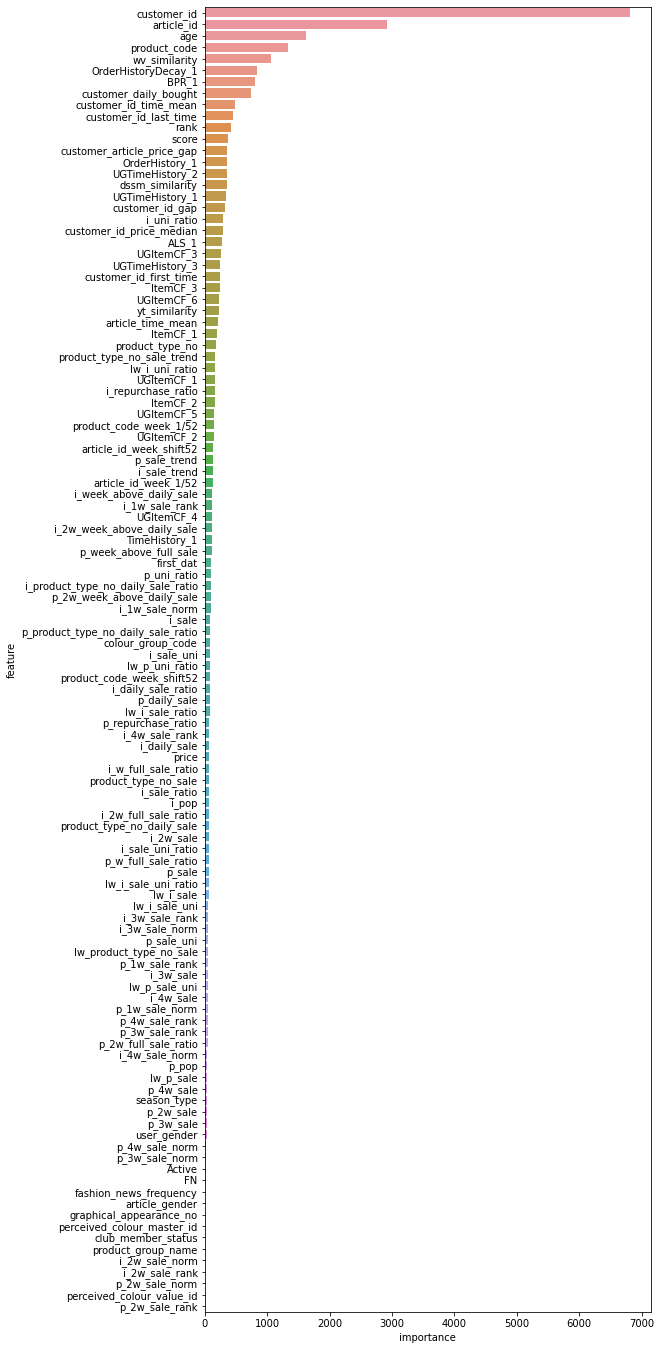

In [ ]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 24))
sns.barplot(y="feature", x="importance", data=feat_importance)

### Validate

In [ ]:
val_candidates = valid.reset_index(drop=True)

In [ ]:
def predict(ranker, candidates, batch_size = 5_000_000):
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        outputs = ranker.predict(candidates.loc[batch : batch + batch_size - 1, feats])
        probs[batch : batch + batch_size] = outputs
    candidates["prob"] = probs
    pred_lgb = candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()
    return pred_lgb

In [ ]:
pred = predict(ranker, val_candidates)

100%|██████████| 89351/89351 [00:07<00:00, 11630.37it/s]


In [ ]:
label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

In [ ]:
map_at_k(label["article_id"], label["prediction"], k=12)

# 0.030474231530210446 ranker, top50
# 0.028997107156740753 binary, top50

0.028997107156740753

In [ ]:
batch_size = 5_000_000
probs = np.zeros(val_candidates.shape[0])
for batch in range(0, val_candidates.shape[0], batch_size):
    outputs = ranker.predict(val_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs
val_candidates["prob"] = probs
pred_lgb = val_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)

In [ ]:
pred_lgb.to_parquet(data_dir/"processed"/"large_binary_valid.pqt")

### Blend

In [ ]:
pred1_lgb_rank = pd.read_parquet(data_dir/"processed"/"large_rank_valid.pqt")
pred1_lgb_binary = pd.read_parquet(data_dir/"processed"/"large_binary_valid.pqt")

In [ ]:
pred2_lgb_rank = pd.read_parquet(data_dir/"processed"/"small_rank_valid.pqt")
pred2_lgb_binary = pd.read_parquet(data_dir/"processed"/"small_binary_valid.pqt")
pred2_nn = pd.read_parquet(data_dir/"processed"/"nn_valid.pqt")
pred2_nn.rename(columns={'article_id':'prediction'},inplace=True)

In [ ]:
pred2_lgb_binary = pred2_lgb_binary.merge(pred2_nn, on=['customer_id','prediction'], how='left')
pred2_lgb_binary['prob'] = pred2_lgb_binary['prob_x'] + pred2_lgb_binary['prob_y']

In [ ]:
pred1_lgb_rank   = pred1_lgb_rank.sort_values(by='prob', ascending=False).reset_index(drop=True)
pred1_lgb_binary = pred1_lgb_binary.sort_values(by='prob', ascending=False).reset_index(drop=True)
pred2_lgb_rank   = pred2_lgb_rank.sort_values(by='prob', ascending=False).reset_index(drop=True)
pred2_lgb_binary = pred2_lgb_binary.sort_values(by='prob', ascending=False).reset_index(drop=True)

In [ ]:
pred1_lgb_rank   = pred1_lgb_rank.groupby('customer_id')['prediction'].apply(list).reset_index()
pred1_lgb_binary = pred1_lgb_binary.groupby('customer_id')['prediction'].apply(list).reset_index()
pred2_lgb_rank   = pred2_lgb_rank.groupby('customer_id')['prediction'].apply(list).reset_index()
pred2_lgb_binary = pred2_lgb_binary.groupby('customer_id')['prediction'].apply(list).reset_index()

In [ ]:
pred1_lgb_rank.rename(columns={'prediction':'large_rank'},inplace=True)
pred1_lgb_binary.rename(columns={'prediction':'large_binary'},inplace=True)
pred2_lgb_rank.rename(columns={'prediction':'small_rank'},inplace=True)
pred2_lgb_binary.rename(columns={'prediction':'small_binary'},inplace=True)

In [ ]:
pred = pred1_lgb_rank.merge(pred1_lgb_binary, on=['customer_id'])\
                    .merge(pred2_lgb_rank, on=['customer_id'])\
                    .merge(pred2_lgb_binary, on=['customer_id'])

In [ ]:
def cust_blend(dt, W = [1,1,1,1]):
    #Create a list of all model predictions
    REC = []

    # Second Try
    REC.append(dt['large_rank'])
    REC.append(dt['large_binary'])
    REC.append(dt['small_rank'])
    REC.append(dt['small_binary'])

    #Create a dictionary of items recommended.
    #Assign a weight according the order of appearance and multiply by global weights
    res = {}
    for M in range(len(REC)):
        for n, v in enumerate(REC[M]):
            if v in res:
                res[v] += (W[M]/(n+1))
            else:
                res[v] = (W[M]/(n+1))

    # Sort dictionary by item weights
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())

    # Return the top 12 items only
    return res

In [ ]:
pred['prediction'] = pred.progress_apply(cust_blend, W = [1.0, 1.0, 1.0, 1.0], axis=1)

100%|██████████| 68984/68984 [00:07<00:00, 9293.37it/s]


In [ ]:
label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

In [ ]:
map_at_k(label["article_id"], label["prediction"], k=12)

0.03208471268497963

### Test

In [ ]:
files = os.listdir(data_dir/"processed"/VERSION_NAME)
for batch in range(TEST_BATCH_NUM):
    chunk_files = [f for f in files if f.startswith(f"week0_candidate_{batch}")]
    for chunk,chunk_file in enumerate(sorted(chunk_files)):
        print(chunk_file)
        test_candidate = pd.read_parquet(data_dir/"processed"/VERSION_NAME/chunk_file)
        test_candidate = test_candidate[test_candidate['rank']<=50].reset_index(drop=True)
        # * ============================================================================================

        tmp = inter.groupby('article_id').week.mean()
        test_candidate['article_time_mean'] = test_candidate['article_id'].map(tmp)

        tmp = inter.groupby('customer_id').week.nth(-1)
        test_candidate['customer_id_last_time'] = test_candidate['customer_id'].map(tmp)

        tmp = inter.groupby('customer_id').week.nth(0)
        test_candidate['customer_id_first_time'] = test_candidate['customer_id'].map(tmp)

        tmp = inter.groupby('customer_id').week.mean()
        test_candidate['customer_id_time_mean'] = test_candidate['customer_id'].map(tmp)

        test_candidate['customer_id_gap'] = test_candidate['customer_id_first_time'] - test_candidate['customer_id_last_time']

        tmp = inter.groupby('customer_id').size()
        test_candidate['customer_daily_bought'] = test_candidate['customer_id'].map(tmp) / test_candidate['customer_id_gap']

        tmp = inter.groupby('customer_id').price.median()
        test_candidate['customer_id_price_median'] = test_candidate['customer_id'].map(tmp)

        test_candidate['customer_article_price_gap'] = test_candidate['customer_id_price_median'] - test_candidate['price']

        del tmp
        gc.collect()

        from itertools import chain
        def dict_union(L):
            return dict(chain.from_iterable(d.items() for d in L))

        dur = [52]
        for col in tqdm(["article_id","product_code"]):
            test_candidate[f'{col}_id_week'] = test_candidate[col].astype('str') + '_' + test_candidate['week'].astype('str')

            for j in dur:
                dict_list = []
                for i in range(5):
                    tmp = inter[(inter['week']>=(1+i+1)) & (inter['week']<(1+i+2+j))]
                    
                    tmp['week'] = i+1
                    tmp = tmp.groupby(['week', col]).size().reset_index()
                    tmp.columns = ['week', col, 'count_sales']

                    tmp[f'{col}_id_week'] = tmp[col].astype('str') + '_'+tmp['week'].astype('str')

                    dict_list.append( dict(zip(tmp[f'{col}_id_week'], tmp['count_sales'])) )
                    del tmp

                dict_all = dict_union(dict_list)
                test_candidate[f'{col}_week_shift{j}'] = test_candidate[f'{col}_id_week'].map(dict_all)

                del dict_all
            gc.collect()

        test_candidate['article_id_week_1/52'] = test_candidate['i_sale'] / test_candidate[f'article_id_week_shift52']
        test_candidate['product_code_week_1/52'] = test_candidate['i_sale'] / test_candidate[f'product_code_week_shift52']

        # * =================================================================================================================

        for feat in cat_features:
            test_candidate[feat] = test_candidate[feat].astype(cate_dict[feat])

        batch_size = 5_000_000
        probs = np.zeros(test_candidate.shape[0])
        for mini_batch in tqdm(range(0, test_candidate.shape[0], batch_size)):
            outputs = ranker.predict(test_candidate.loc[mini_batch : mini_batch + batch_size - 1, feats])
            probs[mini_batch : mini_batch + batch_size] = outputs
        test_candidate["prob"] = probs
        pred_lgb = test_candidate[['customer_id','article_id','prob']]
        pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
        pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
        pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
        pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)

        # pred_lgb.to_parquet(data_dir/"interim"/VERSION_NAME/f"large_binary_test_{batch}_{chunk}.pqt")
        pred_lgb.to_parquet(data_dir/"interim"/VERSION_NAME/f"large_rank_test_{batch}_{chunk}.pqt")

        del test_candidate
        gc.collect()

week0_candidate_0_0.pqt


166

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:19<00:19, 19.96s/it]

0

100%|██████████| 2/2 [00:50<00:00, 25.50s/it]


4

week0_candidate_0_1.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:30<00:30, 30.71s/it]

0

100%|██████████| 3/3 [01:46<00:00, 35.45s/it]


8

week0_candidate_0_2.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:09<00:09,  9.82s/it]

0

100%|██████████| 1/1 [00:00<00:00,  3.70it/s]


4

week0_candidate_1_0.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:21<00:21, 21.25s/it]

0

100%|██████████| 2/2 [01:00<00:00, 30.00s/it]


4

week0_candidate_1_1.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:29<00:29, 29.96s/it]

0

100%|██████████| 3/3 [01:42<00:00, 34.19s/it]


8

week0_candidate_1_2.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:10<00:10, 10.27s/it]

0

100%|██████████| 1/1 [00:00<00:00,  3.71it/s]


4

week0_candidate_2_0.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:22<00:22, 22.64s/it]

0

100%|██████████| 2/2 [01:04<00:00, 32.26s/it]


8

week0_candidate_2_1.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:28<00:28, 28.52s/it]

0

100%|██████████| 3/3 [01:35<00:00, 31.93s/it]


8

week0_candidate_3_0.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:23<00:23, 23.88s/it]

0

100%|██████████| 2/2 [01:09<00:00, 34.75s/it]


8

week0_candidate_3_1.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:27<00:27, 27.16s/it]

0

100%|██████████| 3/3 [01:26<00:00, 28.98s/it]


8

week0_candidate_3_2.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:10<00:10, 10.12s/it]

0

100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


4

week0_candidate_4_0.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:24<00:24, 24.75s/it]

0

100%|██████████| 2/2 [01:16<00:00, 38.09s/it]


4

week0_candidate_4_1.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:25<00:25, 25.55s/it]

0

100%|██████████| 2/2 [01:20<00:00, 40.24s/it]


4

week0_candidate_5_0.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:25<00:25, 25.99s/it]

0

100%|██████████| 2/2 [01:22<00:00, 41.28s/it]


4

week0_candidate_5_1.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:24<00:24, 24.64s/it]

0

100%|██████████| 2/2 [01:16<00:00, 38.32s/it]


4

week0_candidate_6_0.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:27<00:27, 27.57s/it]

0

100%|██████████| 3/3 [01:27<00:00, 29.32s/it]


8

week0_candidate_6_1.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:23<00:23, 23.59s/it]

0

100%|██████████| 2/2 [01:09<00:00, 34.99s/it]


8

week0_candidate_7_0.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:28<00:28, 28.62s/it]

0

100%|██████████| 3/3 [01:33<00:00, 31.28s/it]


8

week0_candidate_7_1.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:21<00:21, 21.84s/it]

0

100%|██████████| 2/2 [01:01<00:00, 30.58s/it]


8

week0_candidate_7_2.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:10<00:10, 10.11s/it]

0

100%|██████████| 1/1 [00:00<00:00,  3.81it/s]


4

week0_candidate_8_0.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:29<00:29, 29.78s/it]

0

100%|██████████| 3/3 [01:39<00:00, 33.14s/it]


8

week0_candidate_8_1.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:20<00:20, 20.63s/it]

0

100%|██████████| 2/2 [00:55<00:00, 27.53s/it]


8

week0_candidate_8_2.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:09<00:09,  9.49s/it]

0

100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


4

week0_candidate_9_0.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:29<00:29, 29.87s/it]

0

100%|██████████| 3/3 [01:35<00:00, 31.88s/it]


12

week0_candidate_9_1.pqt


0

  0%|          | 0/2 [00:00<?, ?it/s]

0

 50%|█████     | 1/2 [00:18<00:18, 18.21s/it]

0

100%|██████████| 2/2 [00:43<00:00, 21.97s/it]


8

In [ ]:
files = os.listdir(data_dir/"interim"/VERSION_NAME)
chunk_files = [f for f in files if f.startswith("large_rank_test")]

In [ ]:
test_l = []
for f in tqdm(chunk_files):
    tmp_df = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f)
    test_l.append(tmp_df)

In [ ]:
test_pred = pd.concat(test_l, ignore_index=True)

In [ ]:
test_pred['customer_id'].nunique()

1371980

In [ ]:
test_pred.to_parquet(data_dir/"processed"/"large_rank_test.pqt")